# [阿里云安全恶意程序检测](https://tianchi.aliyun.com/competition/entrance/231694/introduction?spm=5176.12281973.1005.5.3dd52448mBco6p)


## 赛题背景
恶意软件是一种被设计用来对目标计算机造成破坏或者占用目标计算机资源的软件，传统的恶意软件包括蠕虫、木马等，这些恶意软件严重侵犯用户合法权益，甚至将为用户及他人带来巨大的经济或其他形式的利益损失。近年来随着虚拟货币进入大众视野，挖矿类的恶意程序也开始大量涌现，黑客通过入侵恶意挖矿程序获取巨额收益。当前恶意软件的检测技术主要有特征码检测、行为检测和启发式检测等，配合使用机器学习可以在一定程度上提高泛化能力，提升恶意样本的识别率。

## 赛题说明
本题目提供的数据来自文件（windows 可执行程序）经过沙箱程序模拟运行后的API指令序列，全为windows二进制可执行程序，经过脱敏处理。

本题目提供的样本数据均来自于从互联网。其中恶意文件的类型有感染型病毒、木马程序、挖矿程序、DDOS木马、勒索病毒等，数据总计6亿条。
 
## 数据说明

#### 1）训练数据（train.zip）：调用记录近9000万次，文件1万多个（以文件编号汇总），字段描述如下：
![image.png](./columns_desc.jpg)
注1：一个文件调用的api数量有可能很多，对于一个tid中调用超过5000个api的文件，我们进行了截断，按照顺序保留了每个tid前5000个api的记录。  
注2：不同线程tid之间没有顺序关系，同一个tid里的index由小到大代表调用的先后顺序关系。  
注3：index是单个文件在沙箱执行时的全局顺序，由于沙箱执行时间有精度限制，所以会出现一个index上出现同线程或者不同线程都在执行多次api的情况，可以保证同tid内部的顺序，但不保证连续。
 

#### 2）测试数据（test.zip）：调用记录近8000万次，文件1万多个。
说明：格式除了没有label字段，其他数据规格与训练数据一致。
 
评测指标
1.选手的结果文件包含9个字段：file_id(bigint)、和八个分类的预测概率prob0, prob1, prob2, prob3, prob4, prob5 ,prob6,prob7 (类型double，范围在[0,1]之间，精度保留小数点后5位，prob[removed]=1.0我们会替换为1.0-1e-6)。选手必须保证每一行的|prob0+prob1+prob2+prob3+prob4+prob5+prob6+prob7-1.0|<1e-6，且将列名按如下顺序写入提交结果文件的第一行，作为表头：file_id,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7。

2.分数采用logloss计算公式如下：
![image.png](./logloss_formula.jpg)
M代表分类数，N代表测试集样本数，yij代表第i个样本是否为类别j(`是~1，否~0`)，Pij代表选手提交的第i个样本被预测为类别j的概率(prob)，最终公布的logloss保留小数点后6位。

### Data Analysis

In [5]:
!ls

fight.ipynb         security_test.csv   security_train.csv
security_submit.csv security_test.zip   security_train.zip


In [1]:
base_path = '/Users/mac/Documents/阿里大数据实训/天池/阿里云安全恶意程序检测/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
train_data = pd.read_csv(base_path + 'security_train.csv')
train_data

,file_id,label,api,tid,index
0,1,5,LdrLoadDll,2488,0
1,1,5,LdrGetProcedureAddress,2488,1
2,1,5,LdrGetProcedureAddress,2488,2
3,1,5,LdrGetProcedureAddress,2488,3
4,1,5,LdrGetProcedureAddress,2488,4
...,...,...,...,...,...
89806688,13887,2,NtClose,2336,618
89806689,13887,2,NtClose,2336,619
89806690,13887,2,NtClose,2336,620
89806691,13887,2,NtClose,2336,621


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89806693 entries, 0 to 89806692
Data columns (total 5 columns):
file_id    int64
label      int64
api        object
tid        int64
index      int64
dtypes: int64(4), object(1)
memory usage: 3.3+ GB


In [27]:
features = ['正常', '勒索病毒', '挖矿程序', 'DDoS木马', '蠕虫病毒', '感染型病毒', '后门程序', '木马程序']
features

['正常', '勒索病毒', '挖矿程序', 'DDoS木马', '蠕虫病毒', '感染型病毒', '后门程序', '木马程序']

In [30]:
type(train_data[['label', 'file_id']].groupby(['label']).count())
tmp_df = train_data[['label', 'file_id']].groupby(['label']).count()
print(tmp_df)
counts = tmp_df['file_id'].values.tolist()
counts

        file_id
label          
0      16375107
1       2254561
2       9693969
3       8117585
4        663815
5      33033543
6       4586578
7      15081535


[16375107, 2254561, 9693969, 8117585, 663815, 33033543, 4586578, 15081535]

In [55]:
tmp_s = train_data.groupby(['file_id', 'label'])['label'].unique()

In [79]:
tmp_s.value_counts()

[0]    4978
[5]    4289
[7]    1487
[2]    1196
[3]     820
[6]     515
[1]     502
[4]     100
Name: label, dtype: int64

Text(0.5, 0.98, 'The Distribution Diagram of Different Malicious Programs')

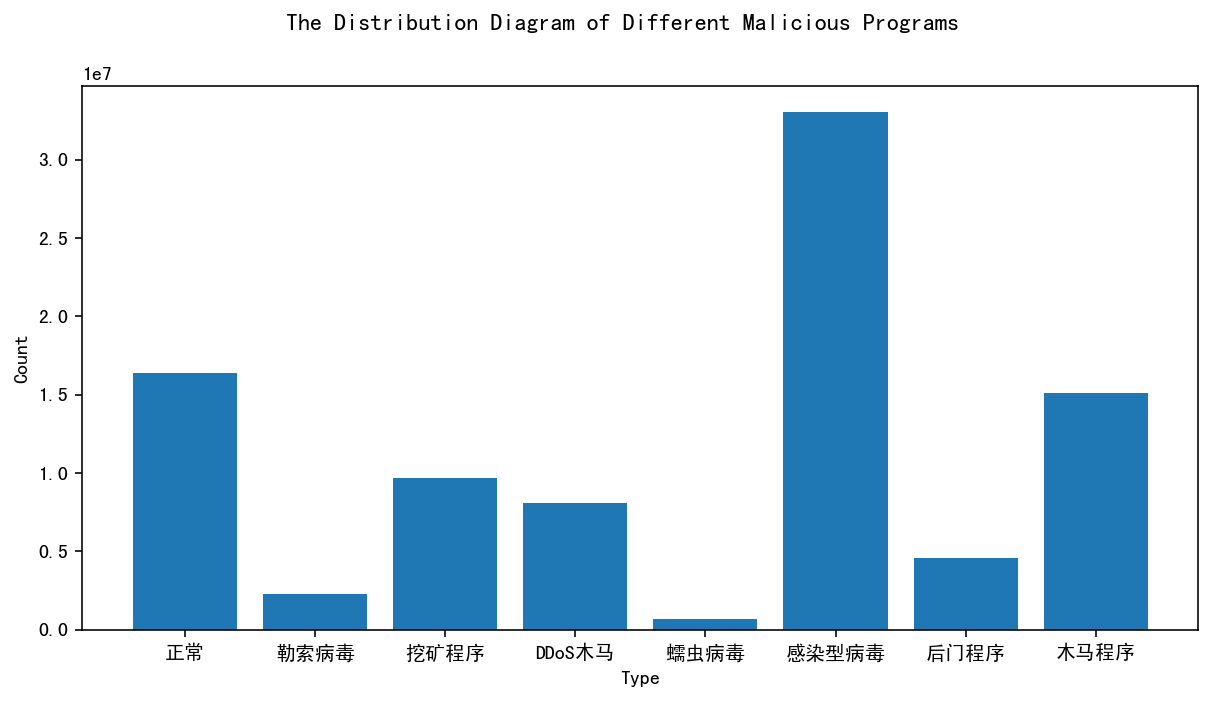

In [29]:
fig = plt.figure(figsize=(10, 5))

plt.bar(features, counts)
plt.xlabel('Type')
plt.ylabel('Count')
plt.suptitle('The Distribution Diagram of Different Malicious Programs')


### Feature Engineering

> Approach_1

* api
* tid
* index

> Approach_2

Feature Cross

* 